In [54]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Diabetes Prediction Using Machine Learning
Data source: https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset

Some **conclusions** are made in this text **without providing sources or references**, such as the selection of features for the prediction models. However, the only used **literature source** is cited below, and the rest is just decisions  made by me based on personal judgment after reviewing the analysis results:

*- Rubin, Alan L. Type 1 Diabetes for Dummies. John Wiley, distributor, 2008.*

**Diabetes** is one of the most prevalent **chronic diseases**, affecting millions globally. This project aims to **predict** the likelihood of an individual having diabetes using the Behavioral Risk Factor Surveillance System **(BRFSS)** dataset from Kaggle.

The focus will be on understanding which **factors contribute the most to diabetes risk** and developing machine learning models to predict diabetes** based on survey responses.**

The first step is to import the necessary libraries. In this case, libraries used were `pandas` for data manipulation, `numpy` for numerical operations, `matplotlib` and `seaborn` for data visualization, ´statsmodels´ for statistical model classes, and `scikit-learn` for machine learning algorithms.

In [55]:
# Import necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, confusion_matrix, roc_curve
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns

The diabetes dataset is loaded using `pandas`. This dataset is saved in a CSV file, so first the data is extracted.

In [56]:
# Load dataset csv
df = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')

This is what the variables of the dataset look like:
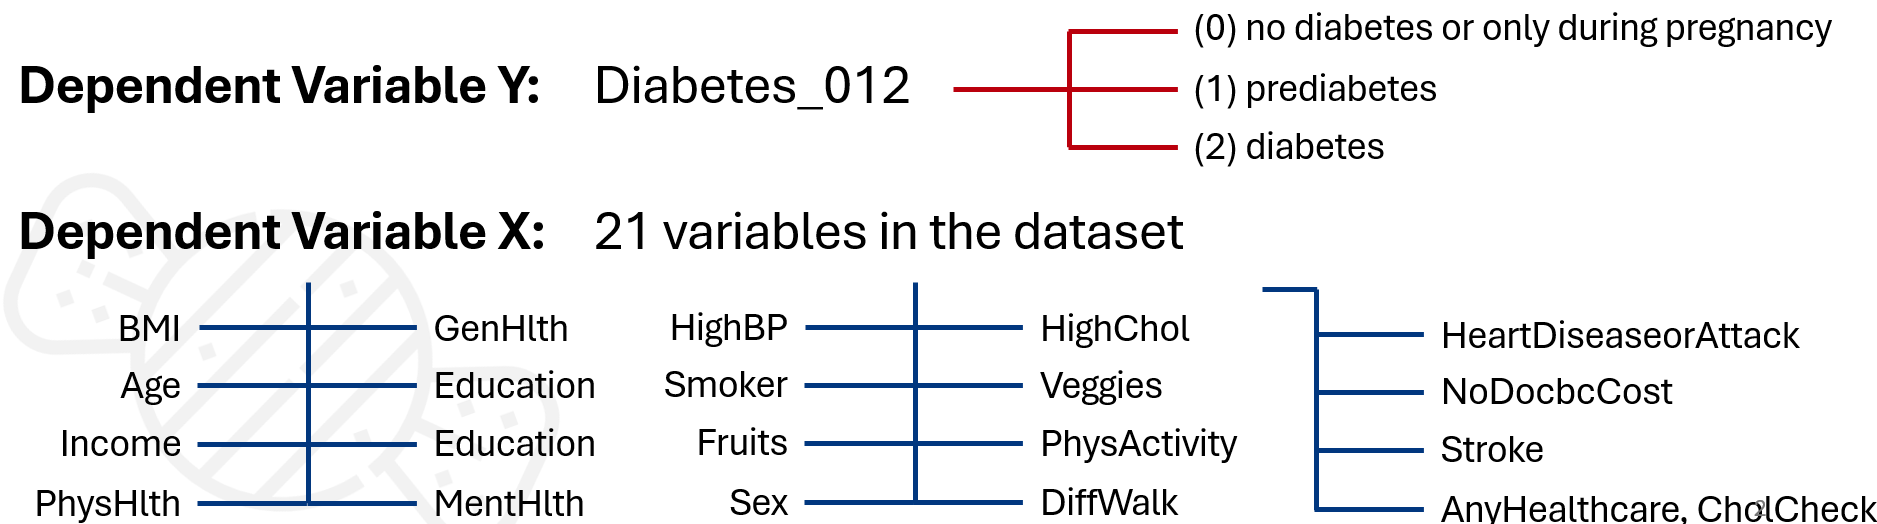

The 21 variables of the dataset also went through some filtering and processing before, from CDC and a Data Scientist:

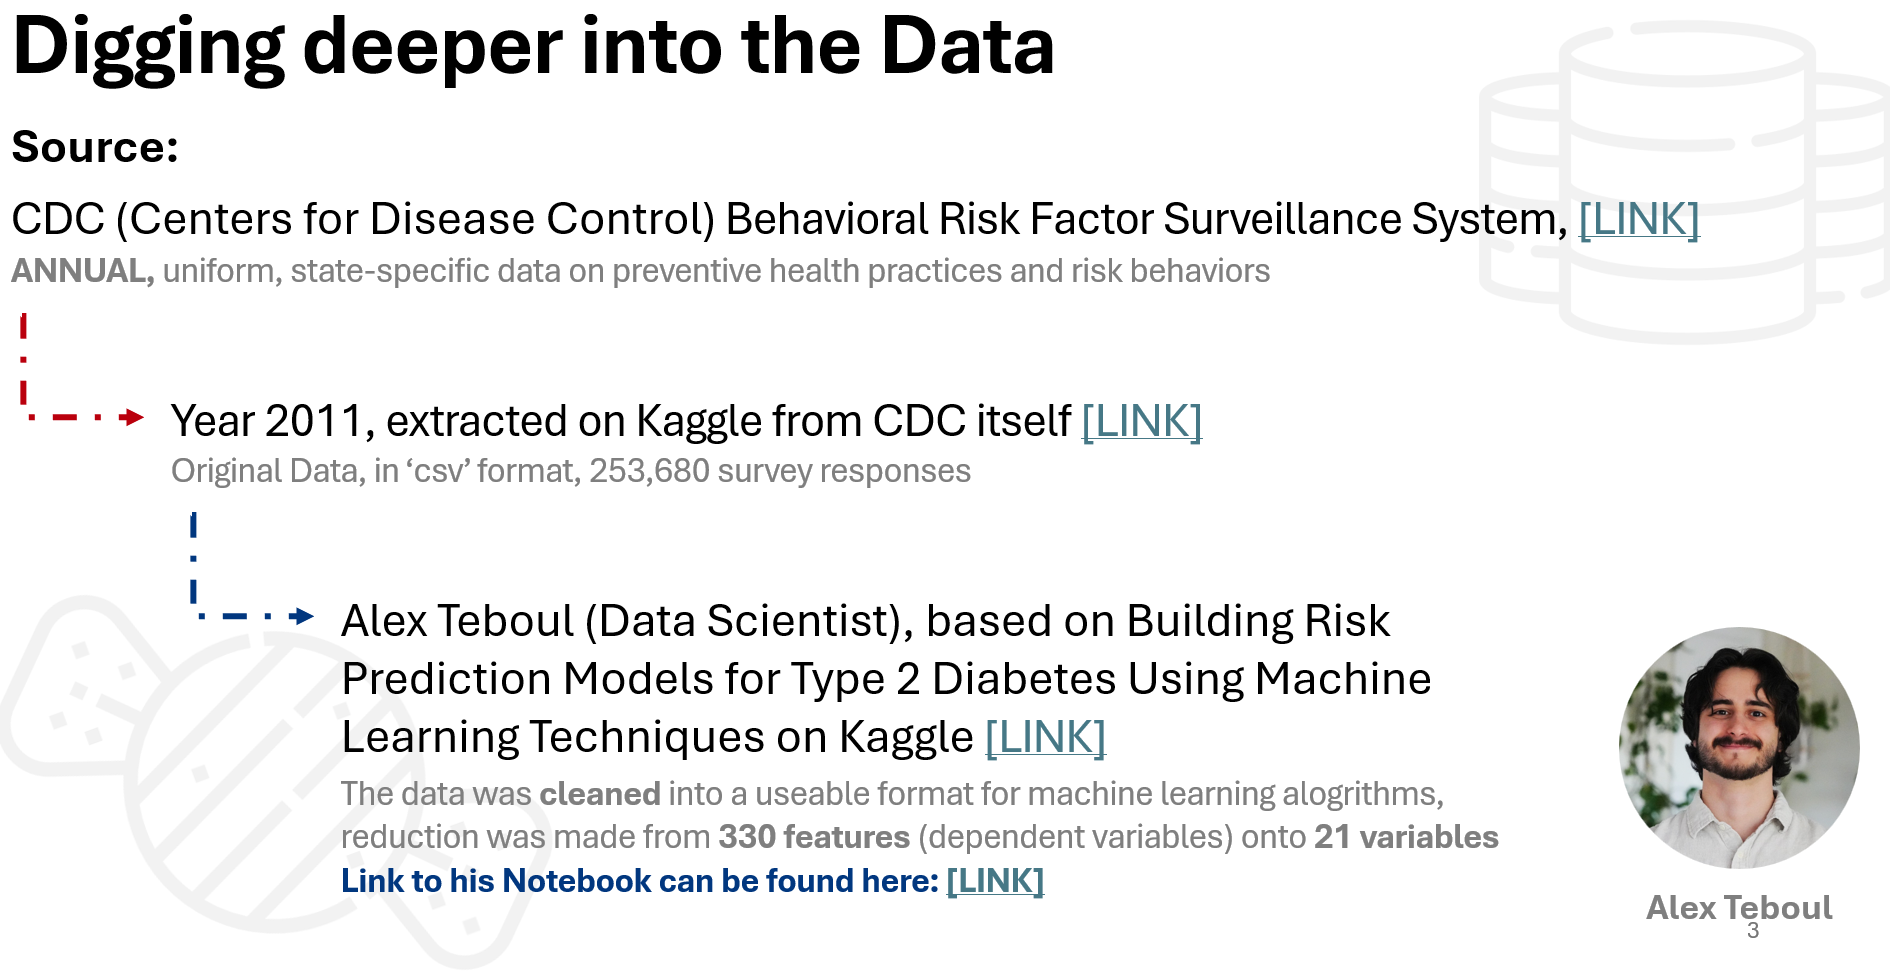

## 1. Data curation

Dataset is now to be split into features X by dropping the "Diabetes_012" column and sets the target variable y to the "Diabetes_012" column.

In [57]:
# Split dataset into features and target
X = df.drop("Diabetes_012", axis=1)
y = df["Diabetes_012"]

Since the target variable `y` is categorical, it will be binarized, in order to ease the process of the prediction. So, `0` will be interpreted as "no diabetes" and `1` as diabetes **or** diabetes. Since there are only 21 features in this dataset, it will be more optimal to first perform some data analysis in order to choose the best features in the next chapter.

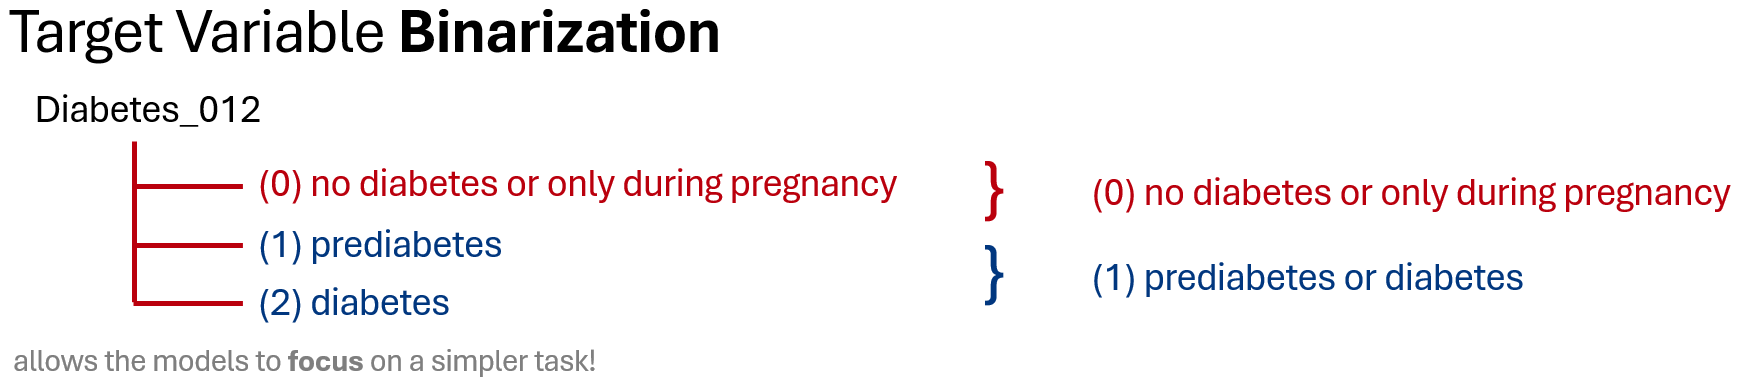

In [58]:
# Binarize target variable: 0 - no diabetes, 1 - prediabetes or diabetes
y_binary = y.apply(lambda x: 1 if x > 0 else 0)

## 2. Exploratory Data Analysis

Now that the data is loaded in the script, some basic **EDA** is able to be made.

In [59]:
# Basic statistics and null value check
df.describe()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.296921,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.698160,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,2.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


It is important to mention that the BRFSS data for age, BMI and education are classified as following:

#### **Education**
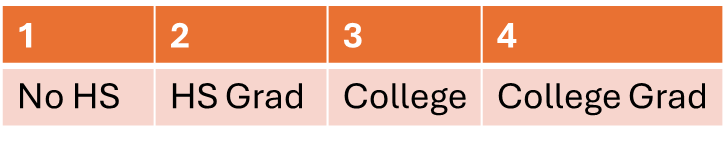

#### **BMI**
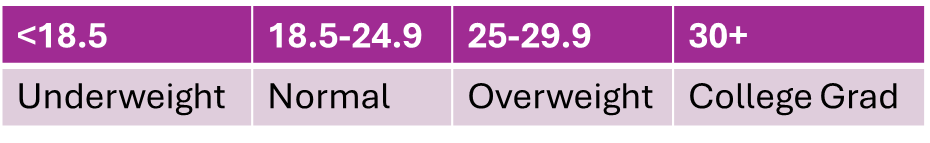

#### **Age**
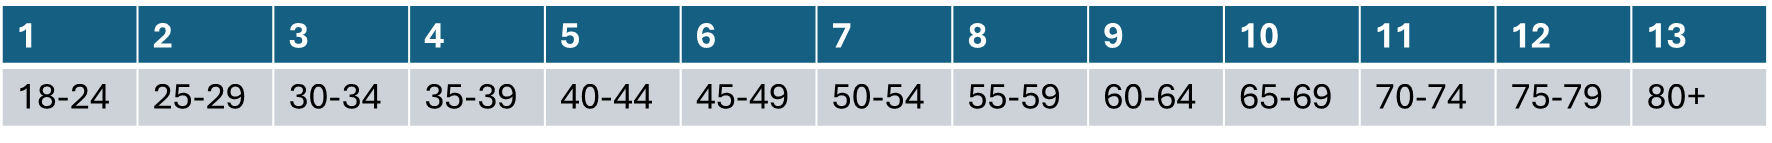

In [60]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [61]:
print(df.isnull().sum())

Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64


-- no variables have null cells saved, so no further processing is needed.

From these basic statistics properties, these points were made about the dataset:
- The **target column**, `Diabetes_012` which represents the diabetes status, has a mean value of around 0.30, indicating a strong imbalance in classes, with the majority of respondents being in the "no diabetes" category.

- The high proportions of respondents with `HighBP` (high blood pressure, **43%**) and `HighChol` (high cholesterol, **42%**), along with an average `BMI` close to the overweight range, highlight these as critical features in the predictive model.

- The high mean of **96%** for `CholCheck` means a very high amount of people had a cholesterol check, so this feature may offer a limited variability for the prediction.

- Binary features, such as `Smoker, Stroke, HeartDiseaseorAttack` show lower proportions (**44%**, **4%** and **9%**), but due to multiple researches, these could also provide potential information for the prediction.

- Lifestyle factors such as `PhysActivity, Fruits, Veggies` have a mean value of **76%, 63%, 62%**, meaning that physical activity, fruit and vegetable consumption could play an important role in diabetes risk prediction.

- Demographics information, like `age, education, income` also have a strong influence on the prediction, with the data indicating that an older age, a moderate-to-high education (health behaviour, access to healthcare) and mid-to-high income level (access to healthcare) can help on predicting the target variable more efficiently.1

In order to address the first point, **undersampling** was chosen as the method to balance the classes in the target variable.

In [62]:
# Apply undersampling to balance the classes
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y_binary)

Now, a data visualization of the **target variable distribution** can be made. First, the binarized data ("no diabetes" and "diabetes or prediabetes") will be plotted and on the other side the undersampled data. This way, we can see the balance of the data (before and after undersampling).

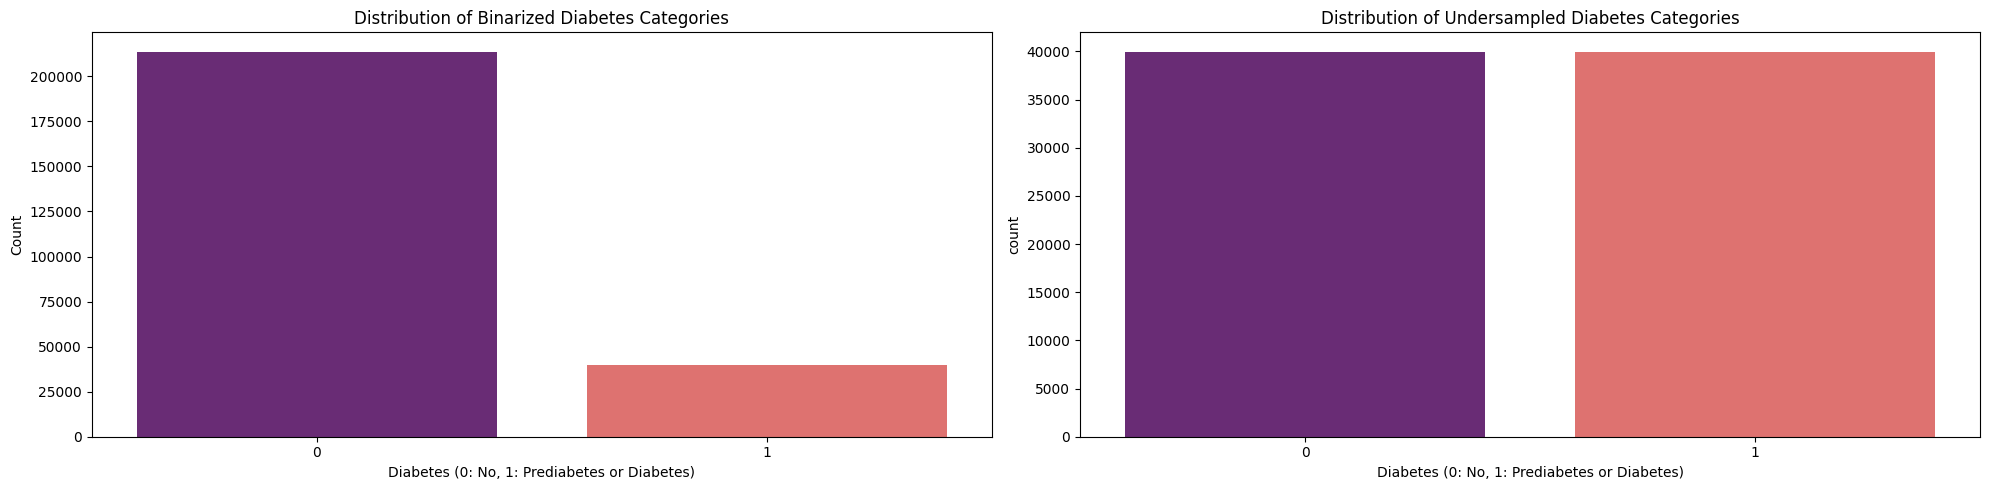

In [63]:
# Plot distribution of the binarized target
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='y_binary', data=pd.DataFrame({'y_binary': y_binary}), palette='magma')
plt.title('Distribution of Binarized Diabetes Categories')
plt.xlabel('Diabetes (0: No, 1: Prediabetes or Diabetes)')
plt.ylabel('Count')

# Plot distribution of the undersampled target
plt.subplot(1, 2, 2)
sns.countplot(x='y_resampled', data=pd.DataFrame({'y_resampled': y_resampled}), palette='magma')
plt.title('Distribution of Undersampled Diabetes Categories')
plt.xlabel('Diabetes (0: No, 1: Prediabetes or Diabetes)')

plt.tight_layout()
plt.show()

Now that the target variable has been balanced, it's interesting to know how the target variable correlates with the features. For this, a **correlation matrix heatmap** will be generated.

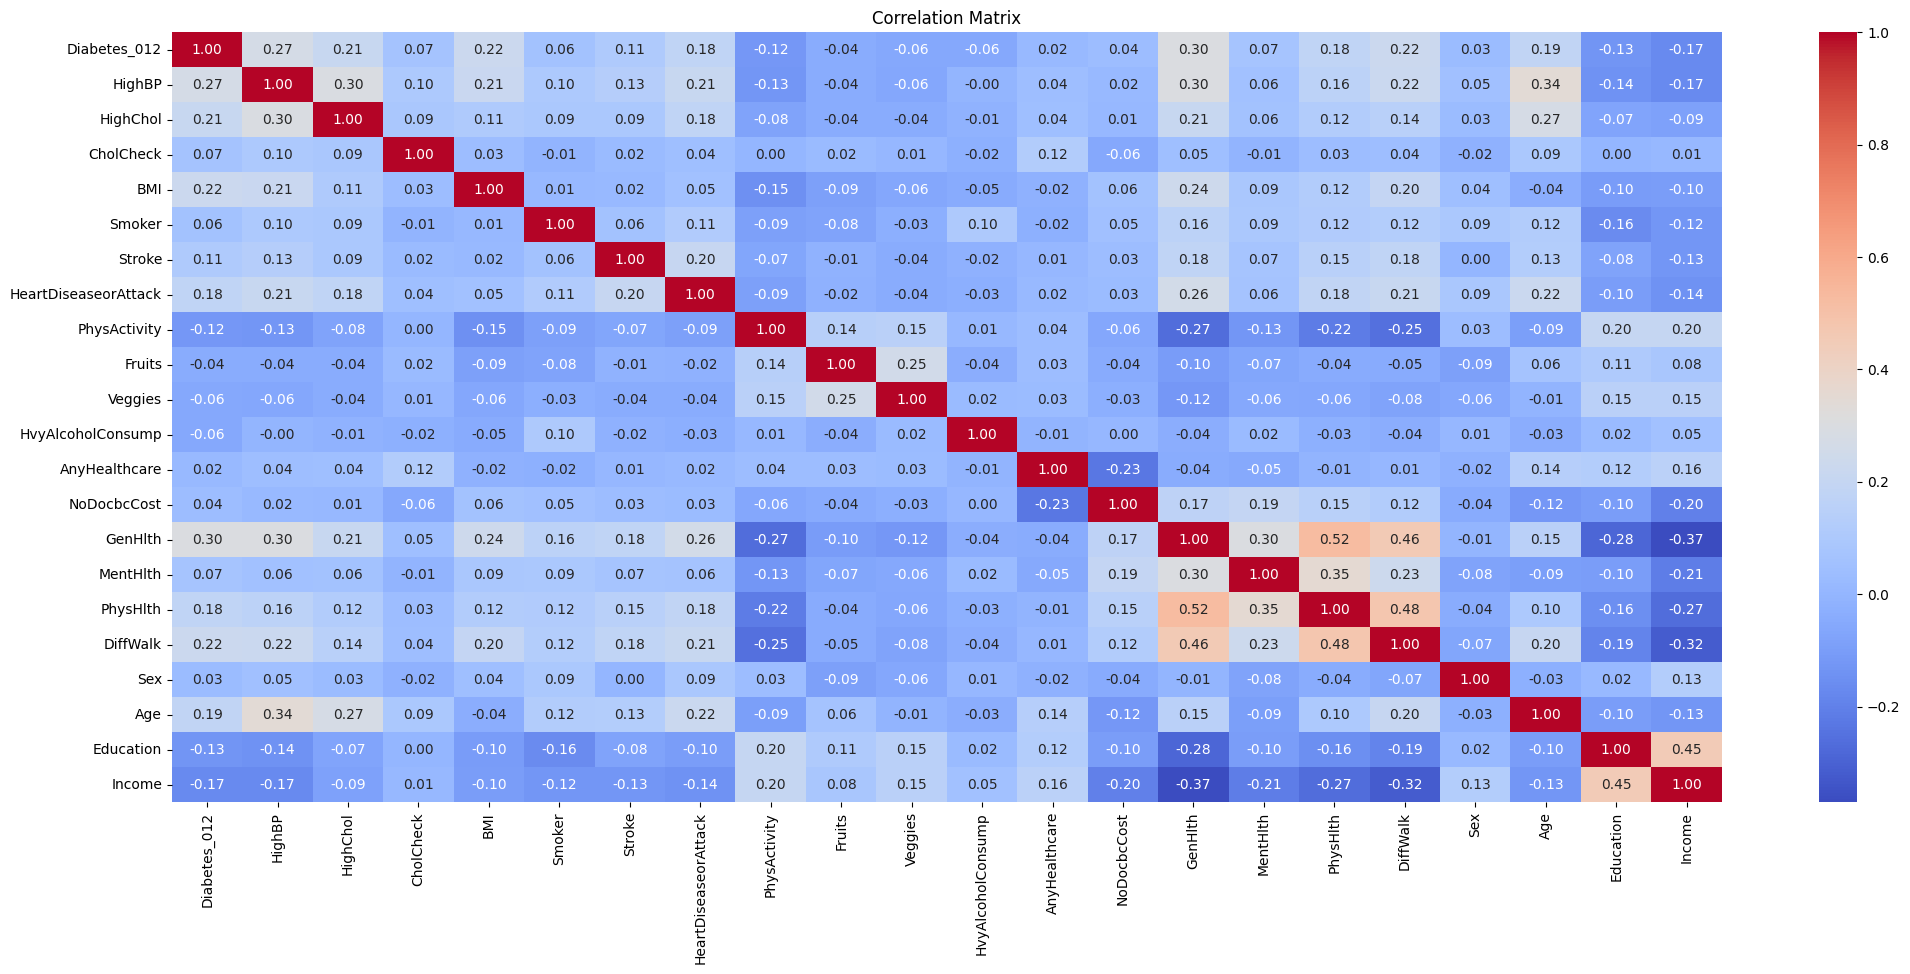

In [64]:
# Correlation matrix heatmap
plt.figure(figsize=(25, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

The correlation matrix shows that the target variable `Diabetes_012` shows notable positive correlations with features like `HighBP`, `HighCol`, `BMI` and `Age`, indicating that these features are significant predictors for diabetes.

With these analysis elements, some of the most important features can be displayed in **pair plots**, in order to see the relationship between each feature and the target variable.

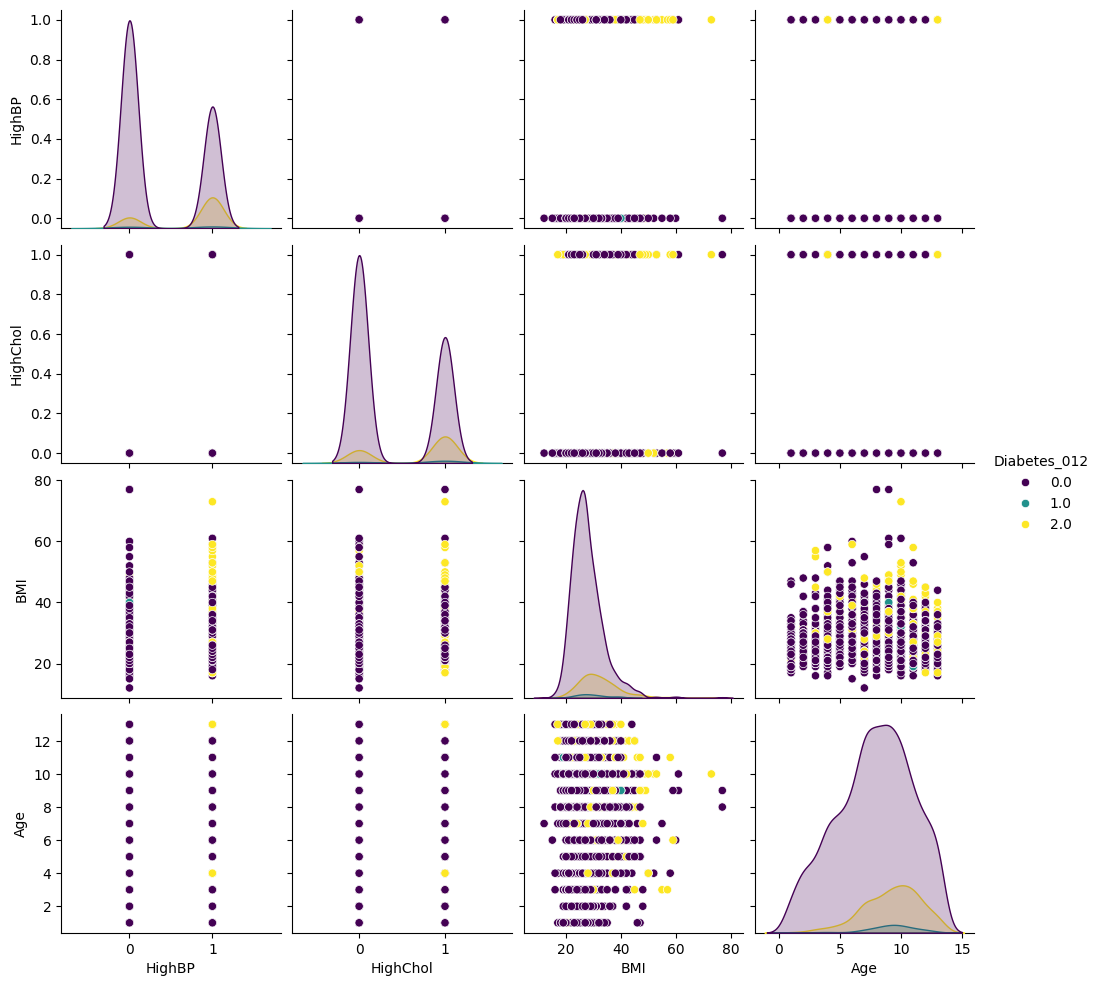

In [65]:
# Sample a subset of the data for faster plotting
sampled_df = df.sample(frac=0.01, random_state=42)  # 1% of the data

# Pair plot with sampled data
selected_features = ['HighBP', 'HighChol', 'BMI', 'Age']
sns.pairplot(sampled_df[selected_features + ['Diabetes_012']], hue='Diabetes_012', palette='viridis')
plt.show()

For the numerical features, such as `BMI`, `Age` and `Income` (based on the results from previous analysis) we can generate **Boxplots** and interpret the results.

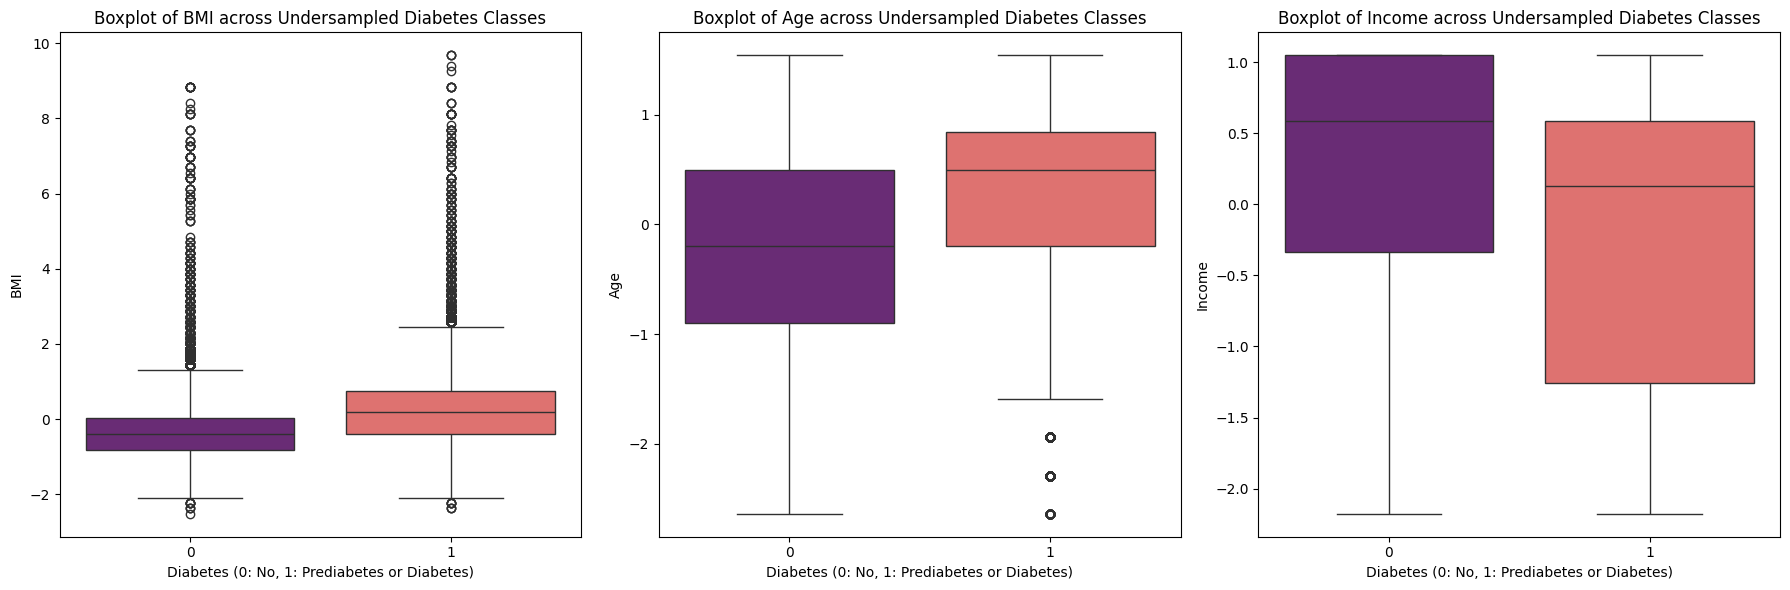

In [66]:
from sklearn.preprocessing import StandardScaler

# Standardize the selected features
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled[['BMI', 'Age', 'Income']])
X_resampled_scaled_df = pd.DataFrame(X_resampled_scaled, columns=['BMI', 'Age', 'Income'])
X_resampled_scaled_df['y_resampled'] = y_resampled.values

# List of selected features for the new plot
selected_features = ['BMI', 'Age', 'Income']

# Create subplots for selected features
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

for i, col in enumerate(selected_features):
    sns.boxplot(ax=axes[i], x='y_resampled', y=col, data=X_resampled_scaled_df, palette='magma')
    axes[i].set_title(f'Boxplot of {col} across Undersampled Diabetes Classes')
    axes[i].set_xlabel('Diabetes (0: No, 1: Prediabetes or Diabetes)')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

From the `Income` Box Plot, it is notable, that the area of a higher income results in **less probability** of individuals being diagnosed with diabetes, which makes it interesting to take this variable further in consideration in our benchmark model.

**Control-to-Treatment Ratio** with the target variable data, is important for the prediction model. So first, the standard control-to-treatment ratio can be calculated (or searched in the model library) and multiple experiments with different ratios were made by changing this control_to_treatment ratio.

In [67]:
# calculate control-to-treatment ratio
control_count = sum(y_resampled == 0)
treatment_count = sum(y_resampled == 1)

control_to_treatment_ratio = control_count / treatment_count
print(f"Control-to-Treatment Ratio: {control_to_treatment_ratio}")

Control-to-Treatment Ratio: 1.0


A summary of the whole EDA analysis can be found in the comparison in chapter 9.

## 3. Univariate Results

An **univariate analysis** can be implemented, and the resulting significant features can be compared to previous research and analysis. The best features will then be taken for the benchmark model, a **multivariate logistic regression**.

In [68]:
X_spec = X_resampled[['HighBP', 'HighChol', 'BMI', 'Age', 'PhysActivity', 'Income', 'GenHlth']]

In [69]:
# reset the index for y_resampled to align indices
y_resampled = pd.Series(y_resampled).reset_index(drop=True)

# standardize the X variables for univariate logistic regression
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_resampled), columns=X_resampled.columns)

# store the results from univariate logistic regressions
logit_results = {}

# perform univariate logistic regression for each feature
for column in X_scaled.columns:
    X_univariate = sm.add_constant(X_scaled[[column]])  # add constant for intercept
    model = sm.Logit(y_resampled, X_univariate).fit(disp=0)
    
    # Calculate AUROC
    y_pred_proba = model.predict(X_univariate)
    auroc = roc_auc_score(y_resampled, y_pred_proba)
    
    logit_results[column] = {
        'coef': model.params[1],
        'p-value': model.pvalues[1],
        'odds_ratio': np.exp(model.params[1])
    }

# convert results to a DataFrame for better readability
univariate_results = pd.DataFrame(logit_results).T.sort_values('p-value')
print("Top features from univariate analysis:")
print(univariate_results.head())

Top features from univariate analysis:
              coef  p-value  odds_ratio
HighBP    0.780275      0.0    2.182072
Age       0.579303      0.0    1.784794
DiffWalk  0.552433      0.0    1.737476
PhysHlth  0.444809      0.0    1.560193
GenHlth   0.914087      0.0    2.494498


In [70]:
# feature selection based on p-values (p < 0.20)
significant_features = univariate_results[univariate_results['p-value'] < 0.20].index
print(f"Significant features selected: {significant_features}")

# Use only significant features for the models
X_significant = X_scaled[significant_features]

Significant features selected: Index(['HighBP', 'Age', 'DiffWalk', 'PhysHlth', 'GenHlth', 'Education',
       'PhysActivity', 'Income', 'BMI', 'HighChol', 'HeartDiseaseorAttack',
       'Stroke', 'CholCheck', 'MentHlth', 'Smoker', 'HvyAlcoholConsump',
       'Veggies', 'Fruits', 'NoDocbcCost', 'Sex', 'AnyHealthcare'],
      dtype='object')


A p_value of < 0.20 is calculated for all 21 features, but from the previous rating, taking the coefficients (coef) also into consideration; HighBP, HighCol, BMI, PhysActivity and HeartDiseaseorAttack performed best.

As a result of both EDA **and** Univariate Analysis, now an X_best can be determined, to be used for the **multivariate regression**.

In [71]:
X_best = X_significant[['HighBP', 'HighChol', 'BMI', 'Age', 'PhysActivity', 'HeartDiseaseorAttack', 'Income', 'GenHlth']]

## 4|5|6|7. Multivariate Logistic Regression and Machine Learning Algorithm using K-Fold Cross-Validation

Now, the **prediction models** can be implemented using these significant features.

Some basic research on the three chosen models:

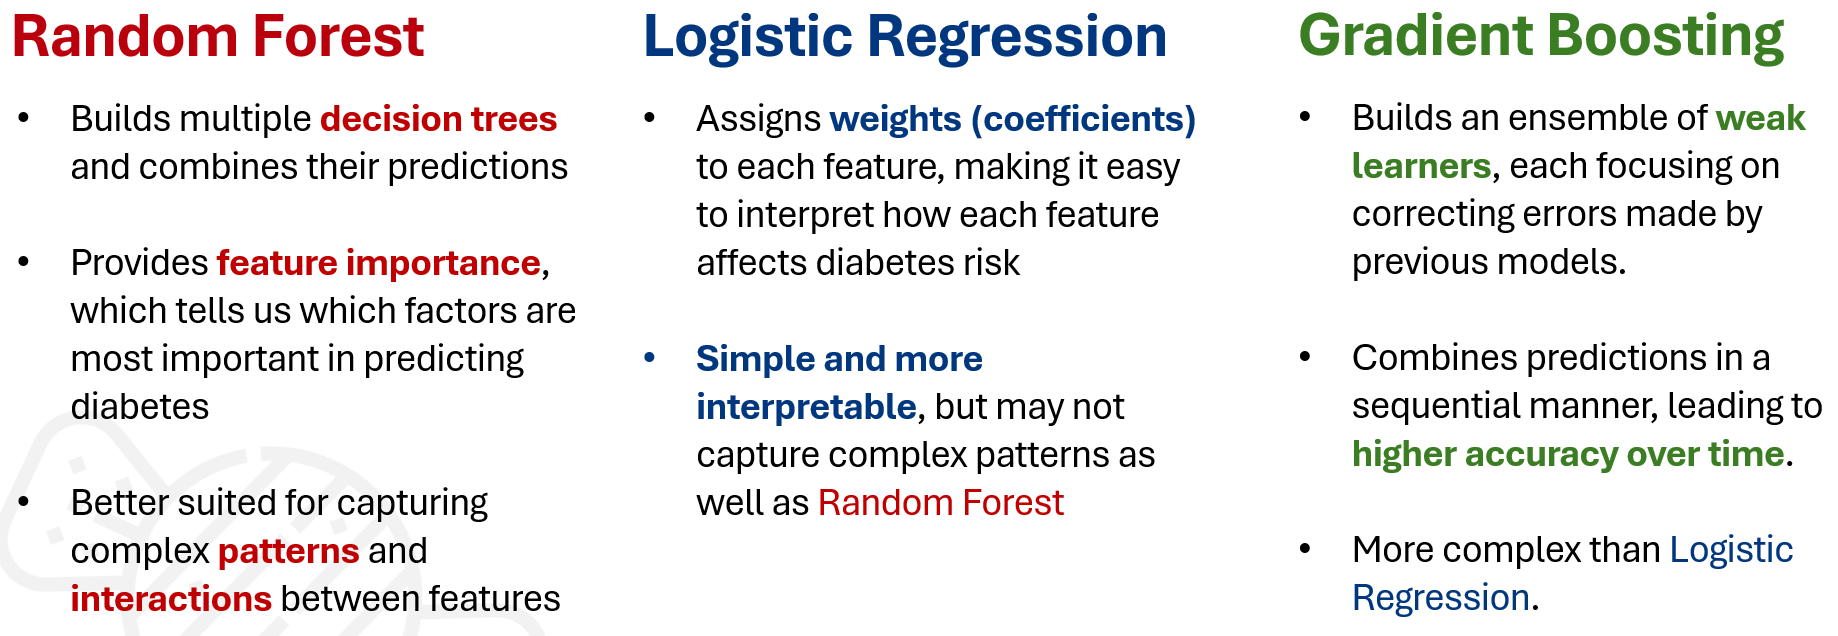

Implementation of the three models:

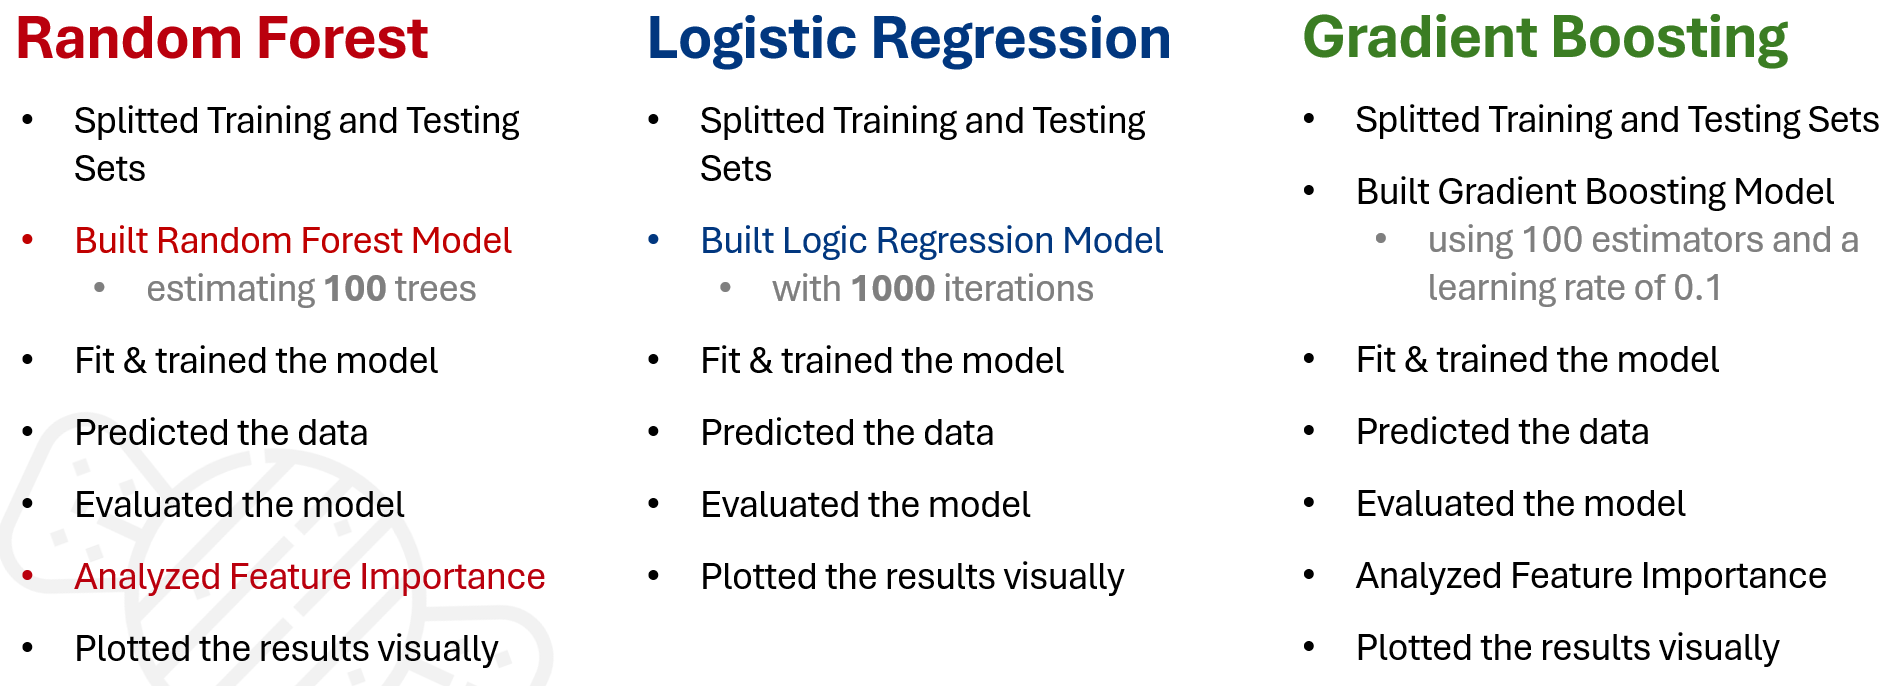



In [72]:
# Define cross-validation method
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize dictionaries to store metrics for each model
metrics_rf = []
metrics_lr = []
metrics_gb = []
feature_importances_rf = []
feature_importances_gb = []

# Perform k-fold cross-validation
fold = 1
y_true_all = []
y_pred_all_rf = []
y_pred_all_gb = []
for train_idx, test_idx in cv.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_idx], X_resampled.iloc[test_idx]
    y_train, y_test = y_resampled.iloc[train_idx], y_resampled.iloc[test_idx]

    # Random Forest
    rf_model = RandomForestClassifier(max_features=5, n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

    # Collect feature importances for Random Forest
    rf_importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    feature_importances_rf.append(rf_importances)

    y_true_all.extend(y_test)
    y_pred_all_rf.extend(y_proba_rf)

    metrics_rf.append({
        'Accuracy': accuracy_score(y_test, y_pred_rf),
        'Precision': precision_score(y_test, y_pred_rf),
        'ROC_AUC': roc_auc_score(y_test, y_proba_rf)
    })
    print(f"Fold {fold} - Random Forest: {metrics_rf[-1]}")

    # Gradient Boosting
    gb_model = GradientBoostingClassifier(max_features=5, n_estimators=100, learning_rate=0.1, random_state=42)
    gb_model.fit(X_train, y_train)
    y_pred_gb = gb_model.predict(X_test)
    y_proba_gb = gb_model.predict_proba(X_test)[:, 1]

    # Collect feature importances for Gradient Boosting
    gb_importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': gb_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    feature_importances_gb.append(gb_importances)

    y_pred_all_gb.extend(y_proba_gb)

    metrics_gb.append({
        'Accuracy': accuracy_score(y_test, y_pred_gb),
        'Precision': precision_score(y_test, y_pred_gb),
        'ROC_AUC': roc_auc_score(y_test, y_proba_gb)
    })
    print(f"Fold {fold} - Gradient Boosting: {metrics_gb[-1]}")

    fold += 1

Fold 1 - Random Forest: {'Accuracy': 0.7302857857544869, 'Precision': 0.7142690875232774, 'ROC_AUC': 0.799706943840901}
Fold 1 - Gradient Boosting: {'Accuracy': 0.748796197861297, 'Precision': 0.7310104529616724, 'ROC_AUC': 0.8238266099904237}
Fold 2 - Random Forest: {'Accuracy': 0.7322869113876556, 'Precision': 0.7169899509231129, 'ROC_AUC': 0.8015593631712666}
Fold 2 - Gradient Boosting: {'Accuracy': 0.7461697204677631, 'Precision': 0.7300140252454418, 'ROC_AUC': 0.8222822715297612}
Fold 3 - Random Forest: {'Accuracy': 0.7281595897692452, 'Precision': 0.7146218091989178, 'ROC_AUC': 0.7978121487260204}
Fold 3 - Gradient Boosting: {'Accuracy': 0.7429178913138641, 'Precision': 0.7290413866289353, 'ROC_AUC': 0.8201586174575718}
Fold 4 - Random Forest: {'Accuracy': 0.7367269088862485, 'Precision': 0.7232837933474876, 'ROC_AUC': 0.8066544216448437}
Fold 4 - Gradient Boosting: {'Accuracy': 0.7522356325433056, 'Precision': 0.7345894394045127, 'ROC_AUC': 0.8293010169875432}
Fold 5 - Random Fo

From the different folds, we can see that the **ROC_AUC for every fold** is almost constant, showing that the subsets of the data were well distributed.

In [73]:
# Logistic Regression Folds
y_true_all_lr = []
y_pred_all_lr = []
fold = 1
for train_idx, test_idx in cv.split(X_best, y_resampled):
    X_train, X_test = X_best.iloc[train_idx], X_best.iloc[test_idx]
    y_train, y_test = y_resampled.iloc[train_idx], y_resampled.iloc[test_idx]

    # Logistic Regression
    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X_train, y_train)
    y_pred_lr = log_reg.predict(X_test)
    y_proba_lr = log_reg.predict_proba(X_test)[:, 1]

    y_true_all_lr.extend(y_test)
    y_pred_all_lr.extend(y_proba_lr)

    metrics_lr.append({
        'Accuracy': accuracy_score(y_test, y_pred_lr),
        'Precision': precision_score(y_test, y_pred_lr),
        'ROC_AUC': roc_auc_score(y_test, y_proba_lr)
    })
    print(f"Fold {fold} - Logistic Regression: {metrics_lr[-1]}")

    fold += 1

Fold 1 - Logistic Regression: {'Accuracy': 0.7372271902945406, 'Precision': 0.7284114175599181, 'ROC_AUC': 0.815597831748895}
Fold 2 - Logistic Regression: {'Accuracy': 0.7387905696954536, 'Precision': 0.7295022842029334, 'ROC_AUC': 0.8128711244302576}
Fold 3 - Logistic Regression: {'Accuracy': 0.7386029641673442, 'Precision': 0.732796486090776, 'ROC_AUC': 0.810928924437203}
Fold 4 - Logistic Regression: {'Accuracy': 0.7451066224751423, 'Precision': 0.7367721671901426, 'ROC_AUC': 0.819733608204978}
Fold 5 - Logistic Regression: {'Accuracy': 0.7358348968105065, 'Precision': 0.7281858889023357, 'ROC_AUC': 0.8109267557389096}


Same goes for the **Logistic Regression** folds, the benchmark model.

In [74]:
# Compute mean metrics for each model
mean_metrics_rf = pd.DataFrame(metrics_rf).mean().to_dict()
mean_metrics_lr = pd.DataFrame(metrics_lr).mean().to_dict()
mean_metrics_gb = pd.DataFrame(metrics_gb).mean().to_dict()

# Print average metrics for each model
print("\nModel Evaluation Metrics (Averaged Across Folds):")

print("\nRandom Forest:")
print(f"Accuracy: {mean_metrics_rf['Accuracy']:.4f}")
print(f"Precision: {mean_metrics_rf['Precision']:.4f}")
print(f"ROC-AUC: {mean_metrics_rf['ROC_AUC']:.4f}")

print("\nLogistic Regression:")
print(f"Accuracy: {mean_metrics_lr['Accuracy']:.4f}")
print(f"Precision: {mean_metrics_lr['Precision']:.4f}")
print(f"ROC-AUC: {mean_metrics_lr['ROC_AUC']:.4f}")

print("\nGradient Boosting:")
print(f"Accuracy: {mean_metrics_gb['Accuracy']:.4f}")
print(f"Precision: {mean_metrics_gb['Precision']:.4f}")
print(f"ROC-AUC: {mean_metrics_gb['ROC_AUC']:.4f}")


Model Evaluation Metrics (Averaged Across Folds):

Random Forest:
Accuracy: 0.7312
Precision: 0.7167
ROC-AUC: 0.8007

Logistic Regression:
Accuracy: 0.7391
Precision: 0.7311
ROC-AUC: 0.8140

Gradient Boosting:
Accuracy: 0.7469
Precision: 0.7307
ROC-AUC: 0.8234


The ROC-AUC is **quite high** for all three models, although the accuracy is at **73-75%**.

Before moving on to the interpretation of the results, we can use the results of the feature importances, in order to find the most **significant features** with our Random Forest and Gradient Boosting models.

## 8. Performance Evaluation

To see how the models have performed, let's start with the **confusion matrix** for each model.

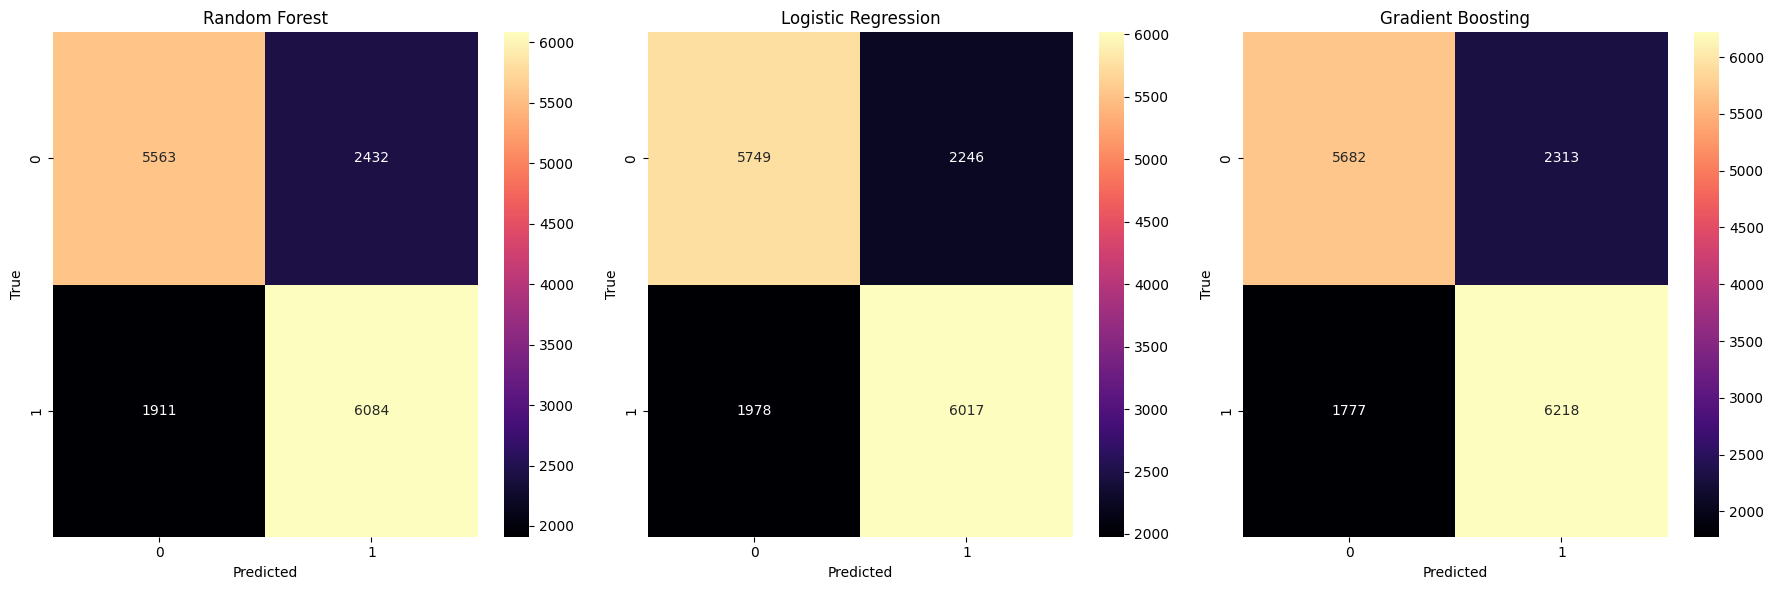

In [75]:
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plotting Random Forest Confusion Matrix
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="magma", ax=axes[0])
axes[0].set_title("Random Forest")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# Plotting Logistic Regression Confusion Matrix
sns.heatmap(conf_matrix_lr, annot=True, fmt="d", cmap="magma", ax=axes[1])
axes[1].set_title("Logistic Regression")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

# Plotting Gradient Boosting Confusion Matrix
sns.heatmap(conf_matrix_gb, annot=True, fmt="d", cmap="magma", ax=axes[2])
axes[2].set_title("Gradient Boosting")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("True")

plt.tight_layout()
plt.show()

As a last step for the **performance evaluation**, before moving to its interpretations, a visualization of the ROC results can be made with the ROC curves for each model.

In [76]:
# calculate ROC curve for each model
fpr_rf, tpr_rf, _ = roc_curve(y_true_all, y_pred_all_rf)
fpr_lr, tpr_lr, _ = roc_curve(y_true_all_lr, y_pred_all_lr)
fpr_gb, tpr_gb, _ = roc_curve(y_true_all, y_pred_all_gb)

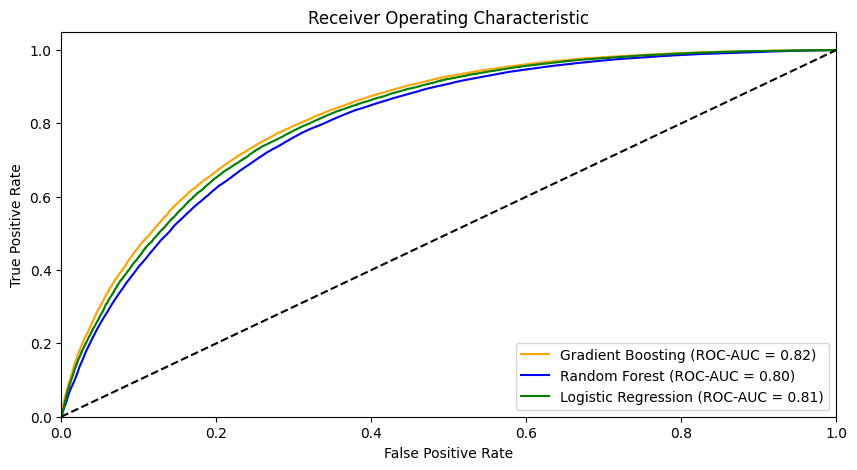

In [77]:
# plot ROC Curves
plt.figure(figsize=(10, 5))
plt.plot(fpr_gb, tpr_gb, label="Gradient Boosting (ROC-AUC = %0.2f)" % mean_metrics_gb['ROC_AUC'], color='orange')
plt.plot(fpr_rf, tpr_rf, label="Random Forest (ROC-AUC = %0.2f)" % mean_metrics_rf['ROC_AUC'], color='blue')
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression (ROC-AUC = %0.2f)" % mean_metrics_lr['ROC_AUC'], color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

## 9. Key Features

**From the EDA** and personal approach, these features were chosen for the benchmark model.

- `HighBP` -> High proportion to positive diabetes, positive correlation in the correlation matrix
- `HighCol` -> High proportion to positive diabetes, positive correlation in the correlation matrix
- `GenHealth` -> Positive correlation in the correlation matrix
- `BMI` -> High proportion to positive diabetes, positive correlation in the correlation matrix
- `PhysActivity`** -> High mean value (not necessarily relevant for diabetes from this information, but I was interested in knowing how this will perform)
- `Age` -> Positive correlation in the correlation matrix
- `Income` -> From the boxplot of the data, it was notable, that the area of a higher income results in less probability of individuals being diagnosed with diabetes

But the machine learning models also made a feature importance rating, which can be analysed. The features were tuned by using the **hyperparameters**, that Random Forest and Gradient Boosting offer.

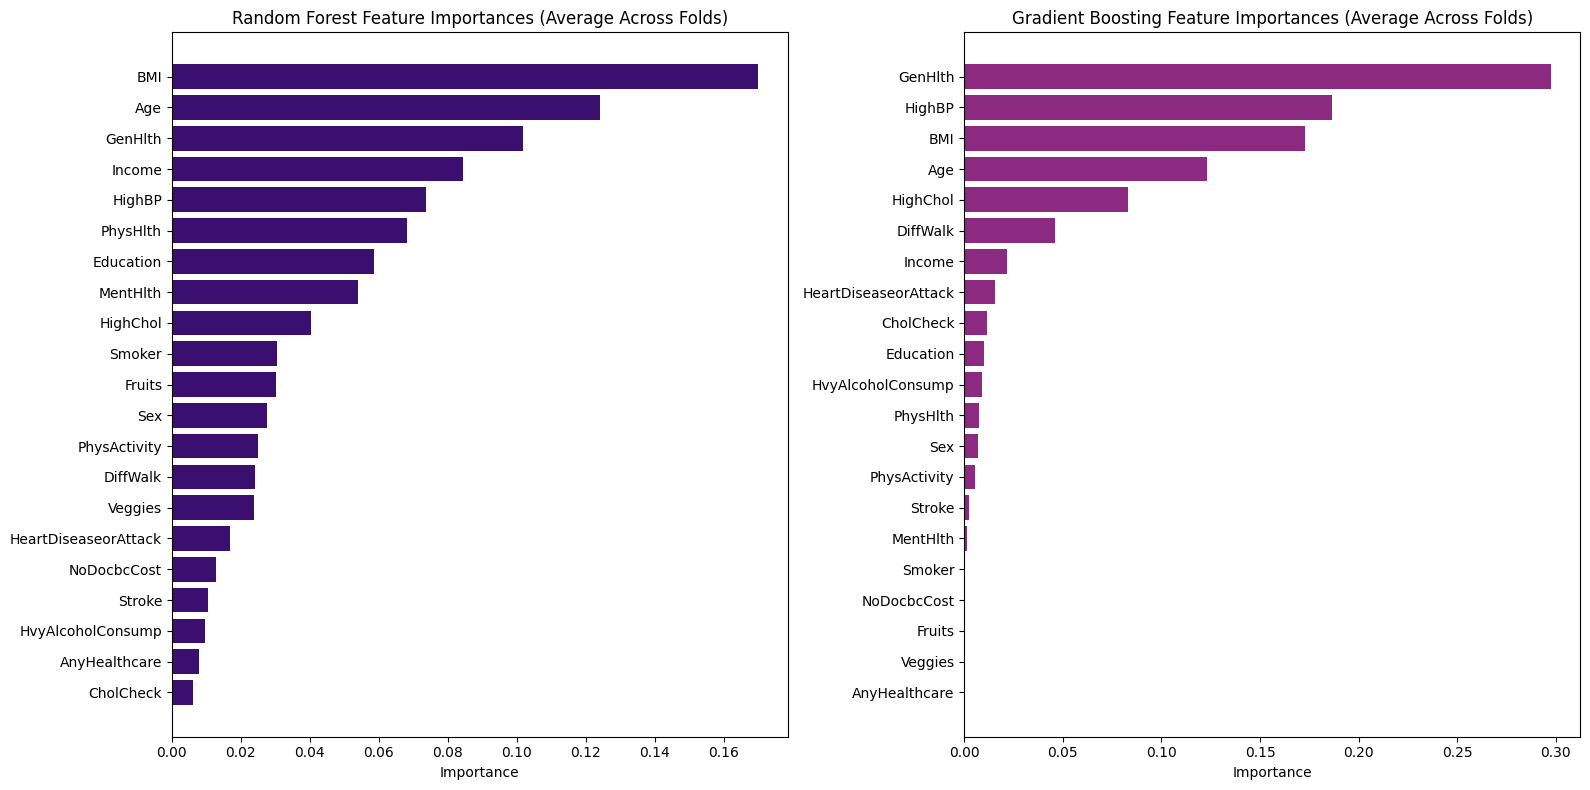

In [78]:
# Average feature importances across all folds
avg_rf_importances = pd.concat(feature_importances_rf).groupby('Feature').mean().sort_values(by='Importance', ascending=False)
avg_gb_importances = pd.concat(feature_importances_gb).groupby('Feature').mean().sort_values(by='Importance', ascending=False)

# Plot feature importances after cross-validation
plt.figure(figsize=(16, 8))

# Random Forest
plt.subplot(1, 2, 1)
plt.barh(avg_rf_importances.index, avg_rf_importances['Importance'], color=plt.get_cmap('magma')(0.2))
plt.title("Random Forest Feature Importances (Average Across Folds)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()

# Gradient Boosting
plt.subplot(1, 2, 2)
plt.barh(avg_gb_importances.index, avg_gb_importances['Importance'], color=plt.get_cmap('magma')(0.4))
plt.title("Gradient Boosting Feature Importances (Average Across Folds)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

From the feature importances, that these models gave, these points can be noted.

- **BMI, Age, High Blood Pressure, High Cholesterol, and General Health** ranked high (as expected).
- However, **Physical Activity** ranked surprisingly low in importance in both model lists.
- On the other side, **Income**, which was a variable where an exact decision couldn't be made in the EDA, performed well in Gradient Boosting, but not so well in Random Forest, with an importance of 0.03 (highest importance was aroudn 0.17).

## 10. Synthetic interpretation of results

When I began this project, I found the dataset both intriguing and personally relevant, given my close experience with diabetes in my family. The dataset contained a substantial amount of data with a wide range of features for analysis. However, the initial challenge was that the target variable (`y`) was categorical. This was resolved by binarizing it into two classes: `No Diabetes` (0) and `Diabetes` (1). 

### Data Exploration and Feature Selection

Following some literature research (referencing *Diabetes for Dummies* cited earlier in this document), I conducted exploratory data analysis (EDA) and univariate analysis. From these analyses and informed decisions outlined in Chapters 2 and 3, the following features were selected for the benchmark model:

- High Blood Pressure  
- High Cholesterol  
- BMI  
- Age  
- Physical Activity  
- Heart Disease or Attack  
- Income  
- General Health  

The benchmark model chosen was a **multivariate logistic regression**, which performed well due to the linear relationships in the data and the carefully selected features. I experimented by removing certain variables (e.g., `Income`), but the best performance was achieved with all the selected features included.

### Machine Learning Models

Building on the benchmark model, I implemented two additional machine learning models:

1. **Random Forest**  
   - Selected for its ability to handle feature importance and capture non-linear relationships.  
   - Despite being less suited for predominantly linear data, it performed very well with an **ROC-AUC of 80%**. However, it was **slightly** outperformed by the benchmark logistic regression model (**ROC-AUC of 81%**).
   - A notable advantage of Random Forest was its ability to achieve comparable results using only 5 features, as opposed to the benchmark model’s 8 features.

2. **Gradient Boosting**  
   - Chosen for its iterative process of boosting trees by learning from previous errors.  
   - Gradient Boosting achieved the best performance with an **ROC-AUC of 82%** while also using just 5 features.  

### Key Insights

The primary objective of this analysis was to achieve a high **ROC-AUC** with fewer variables, resulting in a simpler and more interpretable model. **Gradient Boosting** emerged as the most effective model, meeting this goal perfectly. However, both the benchmark logistic regression and Random Forest models also performed commendably. 

#### Observations on Feature Selection
- **Key Features**: Most of the features identified during EDA and univariate analysis were validated as important by the models.  
- **Physical Activity**: Interestingly, this feature showed minimal direct influence on diabetes prediction in the machine learning models.  
- **Income**: Initially uncertain during analysis, this feature proved valuable for prediction in both Random Forest and Gradient Boosting models.

### Conclusion

Overall, this project was very cool. Experimenting with models, their parameters, and feature tuning provided a comprehensive learning experience. The goal of creating a simplified yet effective model was achieved, with **Gradient Boosting** standing out as the best performer. The lessons learned throughout this process, from data preprocessing to model evaluation, were invaluable.


## 11. Deep Learning (Extra)

Additionally, in order to compare the machine learning models with a deep learning model, it was decided to see how a deep learning model would interact with the data.

After research, it would make sense to use a neural network architecture, with at least two hidden layers, and **dropout layers** to prevent overfitting. The output layer then uses a **sigmoid** activation function, in order to produce probabilites for the binary classification (no diabetes, diabetes).

To train the model, the most common choice for binary classification tasks are **Adam** optimizer and binary cross-entropy, so the Adam optimizer will be used. This one uses momentum (moving averages of gradients) to smooth the updates, and it has an adaptive learning rate that gets adjusted for each parameter

Popular libraries that can achieve these goals are **TensorFlow** and **Keras** in Python.

The deep learning model was generated using **ChatGPT** with these requirements. Following prompt was used:

*Using my diabetes dataset attached, implement a deep learning model for binary classification using TensorFlow and Keras. The target variable is binarized (Diabetes_012 > 0 as 1, else 0), and the data is undersampled.*

*In the code snippet I have attached, the data is already spit into training and testing sets. Build a neural network with at least two hidden layers, use dropout for regularization, and compile the model with adam optimizer and binary cross-entropy loss. Track accuracy and AUROC during training.*

*Train the model for 20 epochs and evaluate it. Provide confusion matrix and ROC curve for interpretation.*

Following code was generated:

In [79]:
# Import tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from imblearn.under_sampling import RandomUnderSampler

# Load dataset csv
df = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')

# Split dataset into features and target
X = df.drop("Diabetes_012", axis=1)
y = df["Diabetes_012"]

# Binarize target variable: 0 - no diabetes, 1 - prediabetes or diabetes
y_binary = y.apply(lambda x: 1 if x > 0 else 0)

# Apply undersampling to balance the classes
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y_binary)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Build the deep learning model
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Define the input shape
    Dense(64, activation='relu'),     # First Dense layer
    Dropout(0.3),                     # Dropout for regularization
    Dense(32, activation='relu'),     # Hidden layer
    Dropout(0.3),
    Dense(1, activation='sigmoid')    # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=32, verbose=1)

# Evaluate the model
y_pred_proba = model.predict(X_test).ravel()
y_pred = (y_pred_proba >= 0.5).astype(int)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Deep Learning Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Deep Learning Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"Deep Learning Model (ROC-AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

ModuleNotFoundError: No module named 'tensorflow'

Using Google Colab, I was able to execute the code. Following **results**:

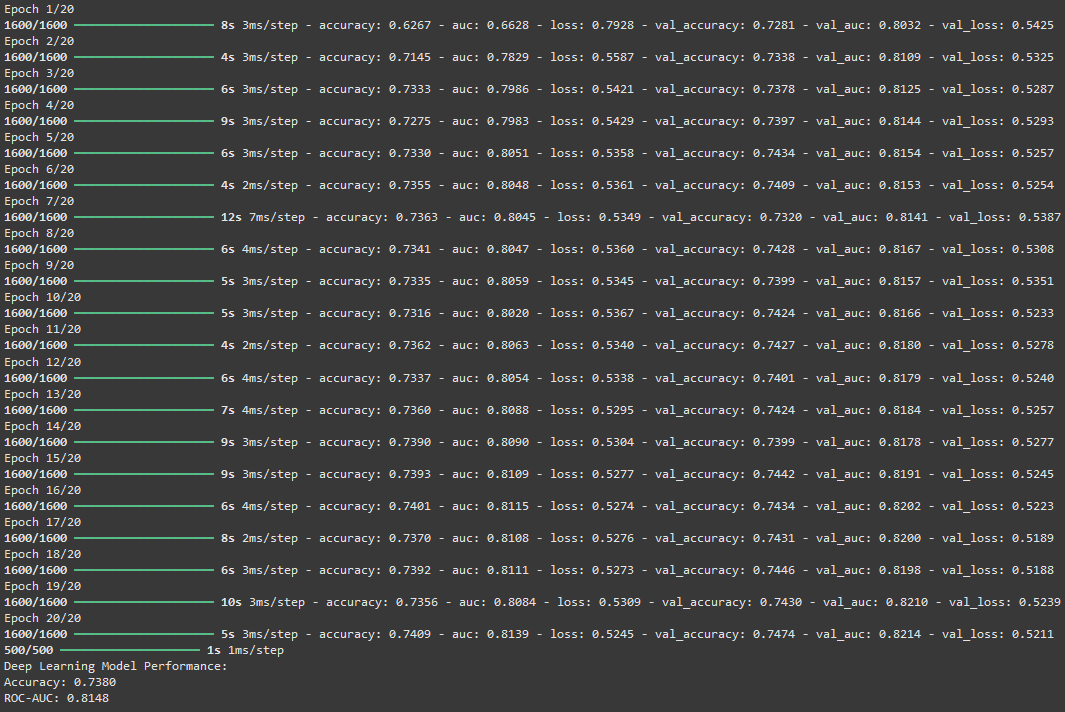

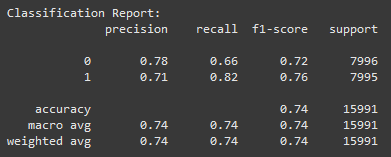

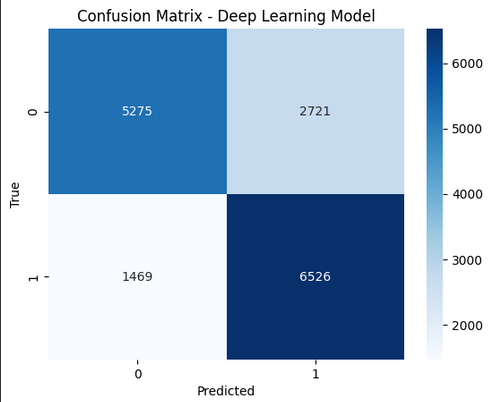
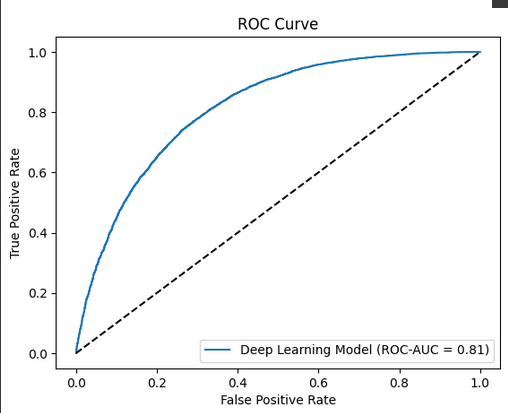

The model performs similarly to Gradient Boosting and its performance is very competitive with all three models from before (ROC-AUC = 0.81). The neural network, however, might **not** have **enough complexity** to significantly outperform the machine learning models from above.

We shouldn't forget that the deep learning model uses more **computational resources** compared to the other three models, though. It could be better for a dataset with much higher complexity, but in this case, the machine learning models are more computationally lightweight and more fit for this type of assignment.

Some more Literature from the Web, used while working on this project:

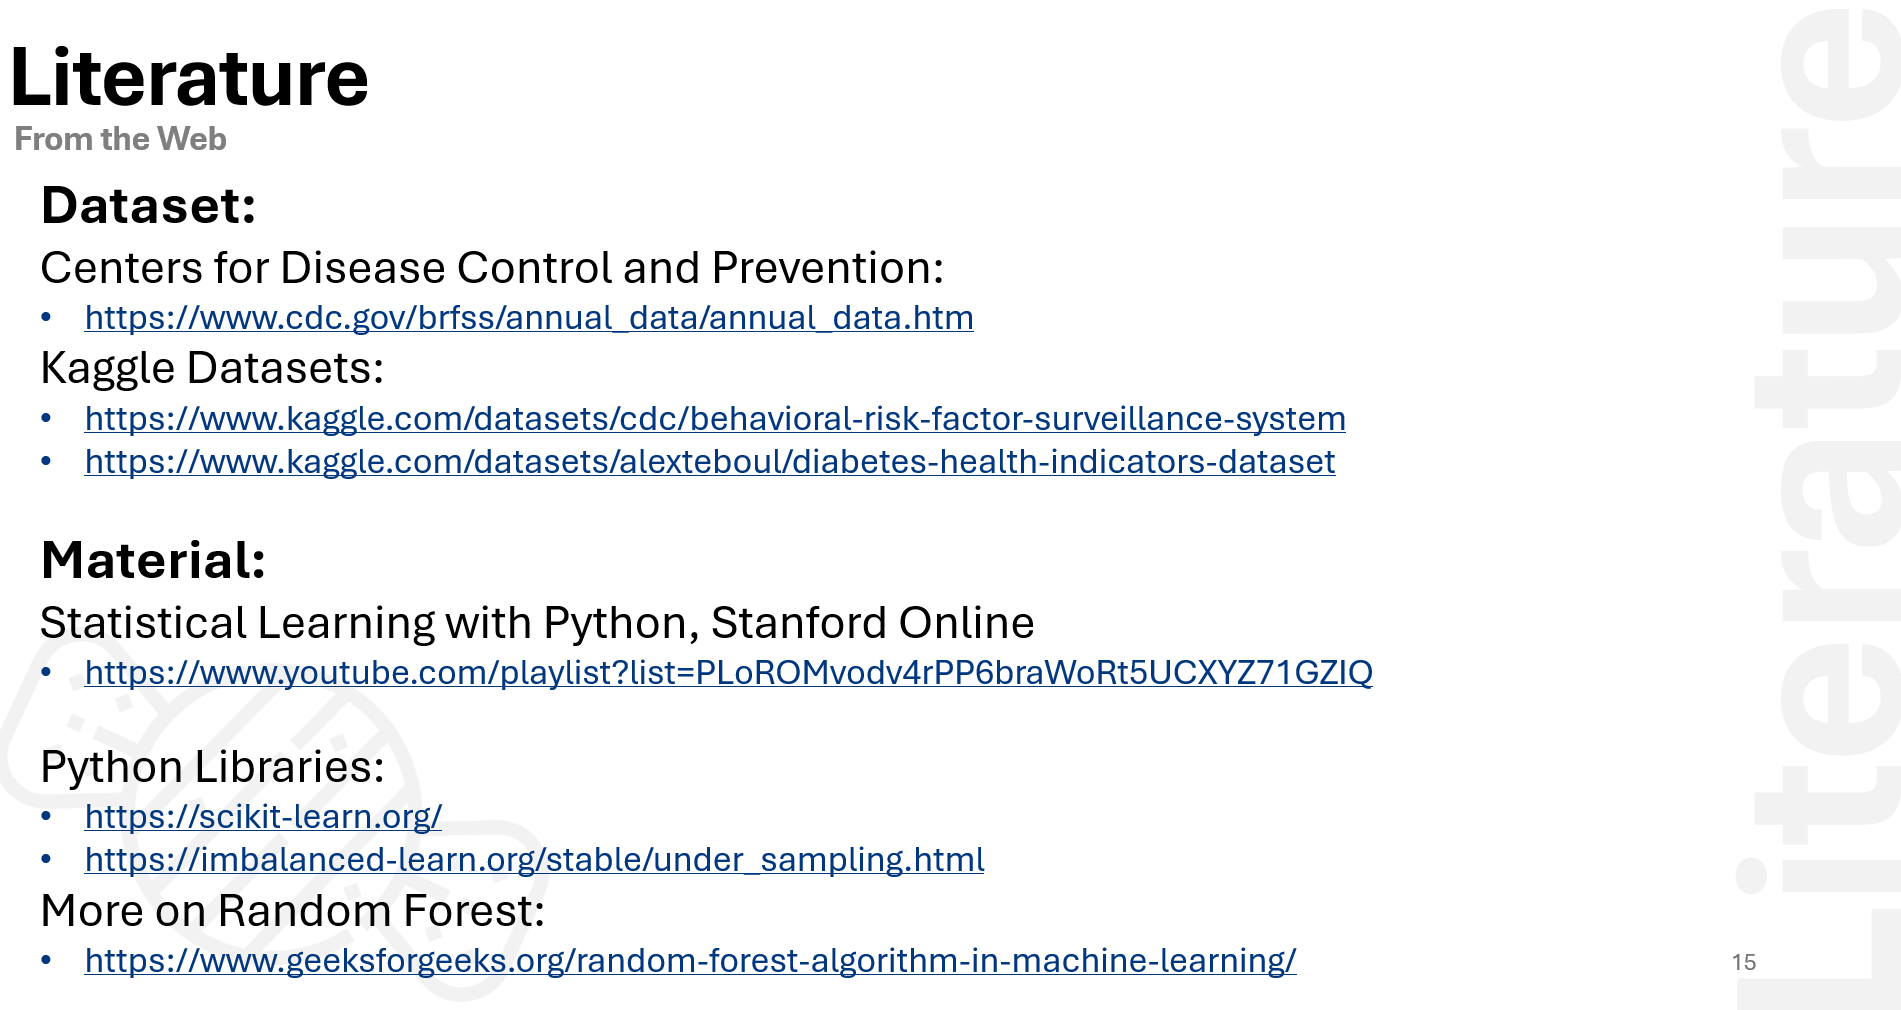